In [69]:
import re
import nltk
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
nltk.download('punkt')
!python -m spacy download en_core_web_sm
from spacy.lang.en import English
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, GRU, SimpleRNN, Conv1D, GlobalMaxPooling1D, MultiHeadAttention, Dropout, Flatten, Bidirectional
from tensorflow.keras.regularizers import l2
from transformers import BertTokenizer, BertModel, TFBertModel
from sklearn.model_selection import KFold, train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

[nltk_data] Downloading package punkt to /Users/venessa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 39.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Data load and preprocessing

In [18]:
# Load data
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")

In [19]:
# Undersample majority class

# Print label counts
print("Training data label counts:")
print(df_train['label'].value_counts())

# Separate majority and minority classes
df_majority = df_train[df_train['label'] == 0]
df_minority = df_train[df_train['label'] == 1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority),     # to match minority class
                                   random_state=42) # reproducible results

# Combine minority class with downsampled majority class
df_train_balanced = pd.concat([df_minority, df_majority_downsampled])

# Shuffle the data
df_train_balanced = df_train_balanced.sample(frac=1).reset_index(drop=True)

# Print updated label counts
print("Balanced training data label counts:")
print(df_train_balanced['label'].value_counts())

Training data label counts:
label
0    8128
1    1410
Name: count, dtype: int64
Balanced training data label counts:
label
0    1410
1    1410
Name: count, dtype: int64


In [20]:
# Prepare train and test data and labels

train_texts = df_train_balanced['content']
test_texts = df_test['content']

train_labels = np.asarray(df_train_balanced['label']).astype('float32')
test_labels = np.asarray(df_test['label']).astype('float32')

### Using Keras tokeniser

Mean sequence length: 432.8641843971631
Maximum sequence length: 1966
Chosen max_len: 734


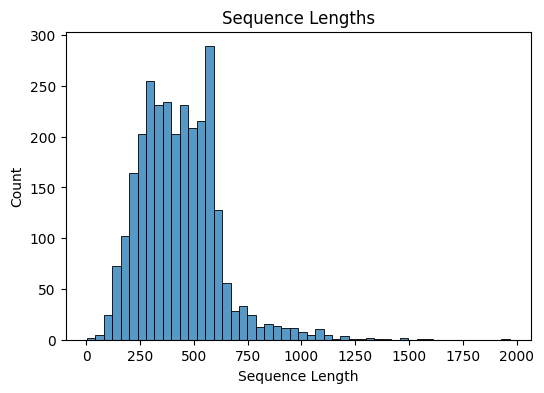

In [21]:
# Find optimal max length for Keras tokeniser

tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(train_texts)
sequences = tokenizer.texts_to_sequences(train_texts)
sequence_lengths = [len(seq) for seq in sequences]

# Print sequence length statistics and choose max_len based on 95th percentile
print(f"Mean sequence length: {np.mean(sequence_lengths)}")
print(f"Maximum sequence length: {np.max(sequence_lengths)}")
max_len_sequences = int(np.percentile(sequence_lengths, 95)) 
print(f"Chosen max_len: {max_len_sequences}")

# Plot sequence lengths
plt.figure(figsize=(6, 4))
sns.histplot(sequence_lengths, bins=50)
plt.title("Sequence Lengths")
plt.xlabel("Sequence Length")
plt.ylabel("Count")
plt.show()


In [22]:
# Preprocessing for RNN using Keras tokeniser

def preprocess_sequences(train_texts, test_texts, num_words=10000, maxlen=max_len_sequences):

    # Initialize and fit the tokenizer
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(train_texts)
    word_index = tokenizer.word_index
    print(f'Found {len(word_index)} unique tokens.')

    # Prepare training data
    train_sequences = tokenizer.texts_to_sequences(train_texts)
    train_sequences = pad_sequences(train_sequences, maxlen=maxlen)

    # Prepare testing data
    test_sequences = tokenizer.texts_to_sequences(test_texts)
    test_sequences = pad_sequences(test_sequences, maxlen=maxlen)
    
    return train_sequences, test_sequences

train_sequences, test_sequences = preprocess_sequences(train_texts, test_texts)


Found 24246 unique tokens.


In [53]:
print("Shape of train_sequences:", train_sequences.shape)
print("Shape of test_sequences:", test_sequences.shape)
print("Shape of train_labels:", train_labels.shape)
print("Shape of test_labels:", test_labels.shape)

Shape of train_sequences: (2820, 734)
Shape of test_sequences: (2385, 734)
Shape of train_labels: (2820,)
Shape of test_labels: (2385,)


### BERT Embeddings

Token indices sequence length is longer than the specified maximum sequence length for this model (590 > 512). Running this sequence through the model will result in indexing errors


Maximum sequence length: 2331
Average sequence length: 526.7673758865249
Chosen max_len: 906.0499999999997


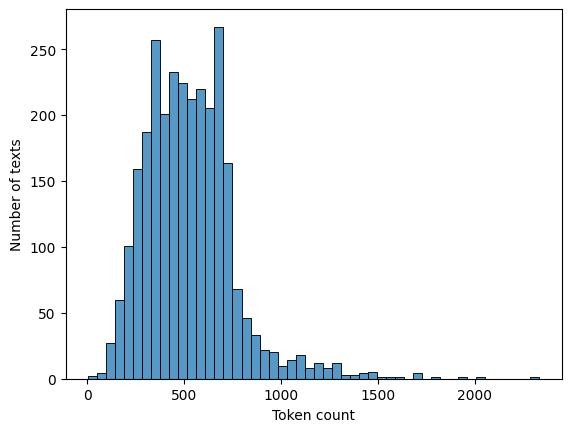

In [7]:
# Find optimal maximum sequence length for BERT

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
df_train = pd.read_csv("../data/train.csv")  # Assuming this is your dataset

# Preliminary tokenization to find optimal max_len
token_lens = []
for txt in train_texts: 
    tokens = tokenizer.encode(txt)
    token_lens.append(len(tokens))

# Analyze the distribution and choose max len based on a value that covers 95% of the texts
print(f"Maximum sequence length: {max(token_lens)}")
print(f"Average sequence length: {np.mean(token_lens)}")
max_len_bert = np.quantile(token_lens, 0.95)
print(f"Chosen max_len: {max_len_bert}")

# Plot the distribution
sns.histplot(token_lens, bins=50)
plt.xlabel('Token count')
plt.ylabel('Number of texts')
plt.show()

In [8]:
# Get BERT embeddings

def preprocess_bert_embeddings(data, max_len):
    
    # Initialize the tokenizer and model if not provided
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = TFBertModel.from_pretrained('bert-base-uncased')

    # Tokenize the text and convert to required format for BERT
    encoded_batch = tokenizer.batch_encode_plus(data.tolist(), 
                                                add_special_tokens=True,
                                                max_length=max_len,
                                                padding='max_length',
                                                truncation=True,
                                                return_attention_mask=True,
                                                return_tensors='tf')

    input_ids = encoded_batch['input_ids']
    attention_mask = encoded_batch['attention_mask']

    # Obtain embeddings
    outputs = model(input_ids, attention_mask=attention_mask)
    embeddings = outputs.last_hidden_state
    
    return embeddings.numpy()

train_embeddings = preprocess_bert_embeddings(train_texts, max_len=512)
test_embeddings = preprocess_bert_embeddings(test_texts, max_len=512)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

: 

## Define Models

In [77]:
class BaseModel(Model):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.num_classes = 1
        self.output = Dense(self.num_classes, activation='sigmoid')
    
    def compile(self, optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']):
        super(BaseModel, self).compile(optimizer=optimizer, loss=loss, metrics=metrics)


In [78]:
class RNNModel(BaseModel):
    def __init__(self, input_shape=(734,), num_classes=1):
        super(RNNModel, self).__init__(num_classes=num_classes)
        self.embedding = Embedding(input_dim=10000, output_dim=300, input_shape=input_shape)
        self.biLSTM = Bidirectional(LSTM(128, return_sequences=True))
        self.dense = Dense(128, activation="relu")
        self.dropout = Dropout(0.1)
    
    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.biLSTM(x)
        x = self.dense(x)
        x = self.dropout(x)
        return self.output(x)
    
class RNNAttentionModel(BaseModel):
    def __init__(self, input_shape=(734,), num_classes=1):
        super().__init__(num_classes)
        self.embedding = Embedding(input_dim=10000, output_dim=32, input_shape=input_shape)
        self.gru = GRU(32)
        self.attention = MultiHeadAttention(num_heads=2, key_dim=2)
        self.flatten = Flatten()

    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.gru(x)
        x = self.attention(x, x)
        x = self.flatten(x)
        return self.dense(x)


In [ ]:
class CNNModel(BaseModel):
    def __init__(self, input_shape=(734,), num_classes=1):
        super(CNNModel, self).__init__(num_classes=num_classes)
        self.embedding = Embedding(input_dim=10000, output_dim=32, input_shape=input_shape)
        self.conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')
        self.pool = GlobalMaxPooling1D()
    
    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.conv1(x)
        x = self.pool(x)
        return self.dense(x)

class CNNAttentionModel(BaseModel):
    def __init__(self, input_shape=(734,), num_classes=1):
        super(CNNAttentionModel, self).__init__(num_classes=num_classes)
        self.embedding = Embedding(input_dim=10000, output_dim=32, input_shape=input_shape)
        self.attention = MultiHeadAttention(num_heads=2, key_dim=64)
        self.conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')
        self.pool = GlobalMaxPooling1D()
        self.dropout = Dropout(0.5)
        self.dense_mid = Dense(64, activation='relu', kernel_regularizer=l2(0.01))
    
    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.attention(x, x)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.dense_mid(x)
        return self.dense(x)


In [75]:
# Functions for model creation, evaluation, and cross-validation

def create_model(model_name):

    if model_name == 'RNN':
        model = RNNModel()
    elif model_name == 'RNN_Attention':
        model = RNNAttentionModel()
    elif model_name == 'CNN':
        model = CNNModel()
    elif model_name == 'CNN_Attention':
        model = CNNAttentionModel()

    model.compile()
    return model

def evaluate(y_true, y_pred_probs, threshold=0.5):
    y_pred_binary = (y_pred_probs >= threshold).astype(int)
    
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred_binary),
        'precision': precision_score(y_true, y_pred_binary),
        'recall': recall_score(y_true, y_pred_binary),
        'f1_score': f1_score(y_true, y_pred_binary),
        'roc_auc': roc_auc_score(y_true, y_pred_probs),
        'confusion_matrix': confusion_matrix(y_true, y_pred_binary)
    }
    
    return metrics

def print_metrics(metrics):
    print("\n=== Evaluation Metrics ===")
    for metric, value in metrics.items():
        if metric != 'confusion_matrix': 
            print(f"{metric.capitalize()}: {value:.4f}")

def plot_graphs(y_true, y_pred_probs, metrics):
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {metrics["roc_auc"]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    # Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

def k_fold_cross_validation(model_name, X, y, num_folds=5, num_epochs=10, batch_size=32):
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    
    # Initialize dictionaries to store scores for each metric across all folds
    aggregated_scores = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'roc_auc': []
    }
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
        print(f"\nTraining on fold {fold+1}/{num_folds}...")
        
        # Split data
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        tf.keras.backend.clear_session()  # Clear previous models from memory.
        model = create_model(model_name)  # You should define this function.
        
        # Train the model
        model.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size,
                  validation_data=(X_val_fold, y_val_fold), verbose=1)
        
        # Generate predictions and evaluate
        y_pred_probs = model.predict(X_val_fold).ravel()
        fold_metrics = evaluate(y_val_fold, y_pred_probs)
        
        # Append the fold's metrics to the aggregated_scores
        for metric in aggregated_scores.keys():
            aggregated_scores[metric].append(fold_metrics[metric])
    
    # After all folds are processed, print aggregated scores
    print(f"Model name: {model_name}")
    print_aggregated_scores(aggregated_scores)

def print_aggregated_scores(aggregated_scores):
    print("\n=== Aggregate Scores Across All Folds ===")
    for metric, scores in aggregated_scores.items():
        average_score = np.mean(scores)
        print(f"{metric.capitalize()}: {average_score:.4f} (± {np.std(scores):.4f})")

def train_and_test(create_model_func, X_train, y_train, X_test, y_test, num_epochs=10, batch_size=32):
    # Clearing the TensorFlow session can help prevent issues related to model/layer duplication
    tf.keras.backend.clear_session()

    # Creating the model using the provided model creation function
    model = create_model_func()

    # Compiling and training the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, verbose=1)

    # Generate predictions
    y_pred_probs = model.predict(X_test).ravel()

    # Evaluate to get metrics
    metrics = evaluate(y_test, y_pred_probs)

    # Print the metrics
    print_metrics(metrics)

    # Plot the graphs
    plot_graphs(y_test, y_pred_probs, metrics)

In [76]:
# Train and evaluate RNN
k_fold_cross_validation('RNN', train_sequences, train_labels)


Training on fold 1/5...
Epoch 1/10


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 734, 1)

In [60]:
# Train and evaluate LSTM
k_fold_cross_validation('LSTM', train_sequences, train_labels)


Training on fold 1/5...
Epoch 1/10


/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.5120 - loss: 0.6930 - val_accuracy: 0.5621 - val_loss: 0.6917
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.6865 - loss: 0.6739 - val_accuracy: 0.5213 - val_loss: 0.6995
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.7565 - loss: 0.5505 - val_accuracy: 0.5284 - val_loss: 0.7669
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.8695 - loss: 0.3585 - val_accuracy: 0.5053 - val_loss: 1.0011
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9546 - loss: 0.1678 - val_accuracy: 0.5053 - val_loss: 1.2606
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.9880 - loss: 0.0643 - val_accuracy: 0.5053 - val_loss: 1.5255
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9968 - loss: 0.0240 - val_accuracy: 0.4982 - val_loss: 1.6961
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9979 - loss: 0.0138 - val_accuracy: 0.4982 - val_loss: 1.

/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.5106 - loss: 0.6934 - val_accuracy: 0.4911 - val_loss: 0.6931
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.5772 - loss: 0.6842 - val_accuracy: 0.5621 - val_loss: 0.6853
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.7253 - loss: 0.6175 - val_accuracy: 0.5621 - val_loss: 0.7327
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.8299 - loss: 0.4282 - val_accuracy: 0.5585 - val_loss: 0.8685
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.9151 - loss: 0.2422 - val_accuracy: 0.5514 - val_loss: 0.9838
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9542 - loss: 0.1458 - val_accuracy: 0.5142 - val_loss: 1.3656
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9810 - loss: 0.0818 - val_accuracy: 0.5301 - val_loss: 1.6012
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9925 - loss: 0.0379 - val_accuracy: 0.5514 - val_loss: 1.

/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.5167 - loss: 0.6931 - val_accuracy: 0.4787 - val_loss: 0.6932
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.6404 - loss: 0.6769 - val_accuracy: 0.5532 - val_loss: 0.6946
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.7712 - loss: 0.5364 - val_accuracy: 0.5550 - val_loss: 0.7560
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.8595 - loss: 0.3789 - val_accuracy: 0.5514 - val_loss: 0.9012
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.9243 - loss: 0.2227 - val_accuracy: 0.5337 - val_loss: 1.0800
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.9595 - loss: 0.1456 - val_accuracy: 0.5355 - val_loss: 1.2598
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.9803 - loss: 0.0727 - val_accuracy: 0.5656 - val_loss: 1.4430
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.9889 - loss: 0.0444 - val_accuracy: 0.5621 - val_loss: 

/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.4996 - loss: 0.6935 - val_accuracy: 0.4752 - val_loss: 0.6938
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.6098 - loss: 0.6856 - val_accuracy: 0.5372 - val_loss: 0.6880
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.7313 - loss: 0.6257 - val_accuracy: 0.5000 - val_loss: 0.7266
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.8467 - loss: 0.4413 - val_accuracy: 0.4716 - val_loss: 0.9133
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 0.9391 - loss: 0.2167 - val_accuracy: 0.4823 - val_loss: 1.1261
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 0.9776 - loss: 0.0995 - val_accuracy: 0.4982 - val_loss: 1.4901
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 0.9909 - loss: 0.0434 - val_accuracy: 0.4947 - val_loss: 1.7102
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.9994 - loss: 0.0208 - val_accuracy: 0.4770 - val

/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.4986 - loss: 0.6936 - val_accuracy: 0.5213 - val_loss: 0.6927
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.6851 - loss: 0.6791 - val_accuracy: 0.5479 - val_loss: 0.7024
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.7603 - loss: 0.5375 - val_accuracy: 0.5284 - val_loss: 0.7684
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.8694 - loss: 0.3618 - val_accuracy: 0.5177 - val_loss: 0.9426
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.9392 - loss: 0.1877 - val_accuracy: 0.5337 - val_loss: 1.0444
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.9743 - loss: 0.0987 - val_accuracy: 0.4911 - val_loss: 1.3436
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.9877 - loss: 0.0562 - val_accuracy: 0.5142 - val_loss: 1.5940
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.9939 - loss: 0.0273 - val_accuracy: 0.4840 - val_

In [65]:
# Train and evaluate GRU
k_fold_cross_validation('GRU', train_sequences, train_labels)


Training on fold 1/5...
Epoch 1/10


/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.5172 - loss: 0.6929 - val_accuracy: 0.5461 - val_loss: 0.6909
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.6317 - loss: 0.6787 - val_accuracy: 0.5621 - val_loss: 0.6912
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.7435 - loss: 0.5535 - val_accuracy: 0.5053 - val_loss: 0.7480
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.8723 - loss: 0.3472 - val_accuracy: 0.5266 - val_loss: 0.9523
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.9144 - loss: 0.2172 - val_accuracy: 0.5177 - val_loss: 1.3131
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.9558 - loss: 0.1254 - val_accuracy: 0.5035 - val_loss: 1.3396
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.9769 - loss: 0.0813 - val_accuracy: 0.5089 - val_loss: 1.5980
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.9901 - loss: 0.0449 - val_accuracy: 0.5106 - val_

/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.4926 - loss: 0.6932 - val_accuracy: 0.5674 - val_loss: 0.6919
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.6547 - loss: 0.6798 - val_accuracy: 0.5479 - val_loss: 0.7078
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.7302 - loss: 0.5655 - val_accuracy: 0.5213 - val_loss: 0.7750
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.8389 - loss: 0.3791 - val_accuracy: 0.5266 - val_loss: 1.0992
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.9078 - loss: 0.2344 - val_accuracy: 0.5142 - val_loss: 1.1512
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.9661 - loss: 0.1228 - val_accuracy: 0.5160 - val_loss: 1.6249
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.9736 - loss: 0.0774 - val_accuracy: 0.5355 - val_loss: 1.8098
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.9905 - loss: 0.0362 - val_accuracy: 0.5284 - val_

/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.4960 - loss: 0.6927 - val_accuracy: 0.5177 - val_loss: 0.6922
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.6793 - loss: 0.6775 - val_accuracy: 0.5248 - val_loss: 0.6989
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.7541 - loss: 0.5708 - val_accuracy: 0.5248 - val_loss: 0.7907
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.8292 - loss: 0.3910 - val_accuracy: 0.5160 - val_loss: 0.9282
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.9050 - loss: 0.2485 - val_accuracy: 0.5018 - val_loss: 1.1594
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.9454 - loss: 0.1581 - val_accuracy: 0.5479 - val_loss: 1.2950
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.9685 - loss: 0.0947 - val_accuracy: 0.5372 - val_loss: 1.6731
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.9762 - loss: 0.0626 - val_accuracy: 0.5355 - val_

/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 0.4965 - loss: 0.6933 - val_accuracy: 0.4805 - val_loss: 0.6946
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.5745 - loss: 0.6797 - val_accuracy: 0.5177 - val_loss: 0.7024
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.7559 - loss: 0.5450 - val_accuracy: 0.5195 - val_loss: 0.8088
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.8554 - loss: 0.3517 - val_accuracy: 0.5124 - val_loss: 1.0888
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.9260 - loss: 0.1863 - val_accuracy: 0.5106 - val_loss: 1.2491
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.9627 - loss: 0.1097 - val_accuracy: 0.5213 - val_loss: 1.5344
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9772 - loss: 0.0774 - val_accuracy: 0.5124 - val_loss: 1.8679
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.9944 - loss: 0.0270 - val_accuracy: 0.4911 

/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.4990 - loss: 0.6933 - val_accuracy: 0.5213 - val_loss: 0.6927
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.6571 - loss: 0.6819 - val_accuracy: 0.5160 - val_loss: 0.7107
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.7502 - loss: 0.5400 - val_accuracy: 0.5284 - val_loss: 0.7840
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.8673 - loss: 0.3441 - val_accuracy: 0.4911 - val_loss: 1.0006
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.9339 - loss: 0.1910 - val_accuracy: 0.4982 - val_loss: 1.2009
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.9533 - loss: 0.1273 - val_accuracy: 0.4876 - val_loss: 1.6058
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.9844 - loss: 0.0511 - val_accuracy: 0.5000 - val_loss: 1.7295
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.9938 - loss: 0.0325 - val_accuracy: 0.4574 - va

In [66]:
# Train and evaluate RNN with Attention
k_fold_cross_validation('RNN_Attention', train_sequences, train_labels)


Training on fold 1/5...
Epoch 1/10


/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


IndexError: Exception encountered when calling Softmax.call().

[1mtuple index out of range[0m

Arguments received by Softmax.call():
  • inputs=tf.Tensor(shape=(None, 2), dtype=float32)
  • mask=None

In [ ]:
# Train and evaluate CNN 
k_fold_cross_validation('CNN', train_sequences, train_labels)

In [ ]:
# Train and evaluate CNN with Attention
k_fold_cross_validation('CNN_Attention', train_sequences, train_labels)

Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.5376 - loss: 0.6944
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.7768 - loss: 0.6150
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.8500 - loss: 0.4690
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.9431 - loss: 0.2943
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9851 - loss: 0.1149
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9946 - loss: 0.0565
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 1.0000 - loss: 0.0258
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 1.0000 - loss: 0.0108
Epoch 9/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9833 - loss: 0.0657
Epoch 10/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.9938 - loss: 0.0306
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

=== Evaluation Metrics ===
Accuracy: 0.5107
Precision: 0.1600
Recall: 0.5027
F1_score: 0.2427
Roc_auc: 0.519

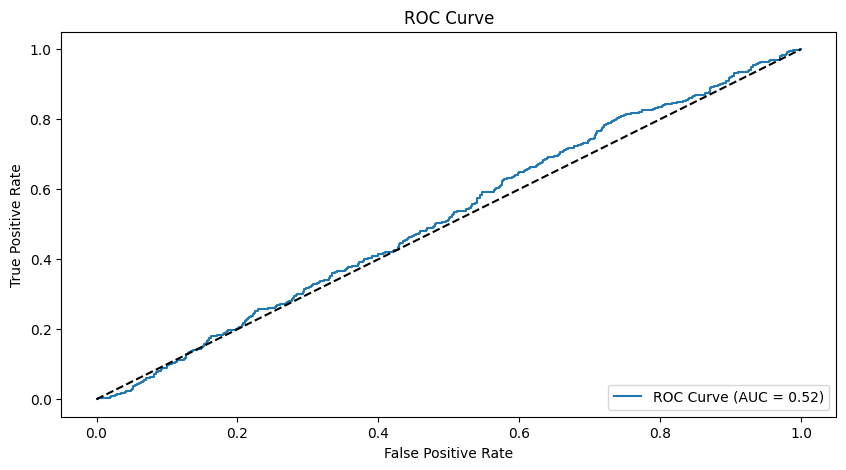

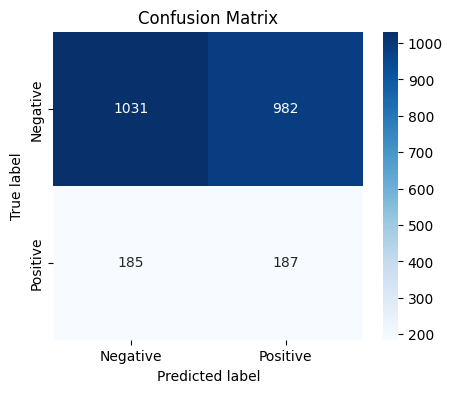

In [62]:
# Test RNN
train_and_test(RNNModel, train_sequences, train_labels, test_sequences, test_labels)

Epoch 1/10


/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.5065 - loss: 0.6927
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.6576 - loss: 0.6739
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - accuracy: 0.7028 - loss: 0.5932
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.7684 - loss: 0.5136
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.8347 - loss: 0.4152
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - accuracy: 0.8982 - loss: 0.3038
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.9412 - loss: 0.2226
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - accuracy: 0.9657 - loss: 0.1403
Epoch 9/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - accuracy: 0.9863 - loss: 0.0791
Epoch 10/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - accuracy: 0.9952 - loss: 0.0442
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step

=== Evaluation Metrics ===
Accuracy: 0.4876
Precision: 0.1589
Recall: 0.5323
F1_score: 0.2447
Roc_auc: 0.525

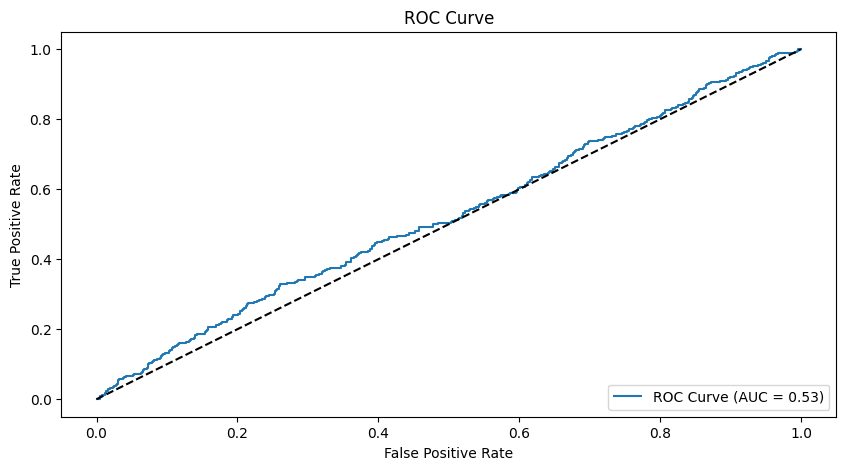

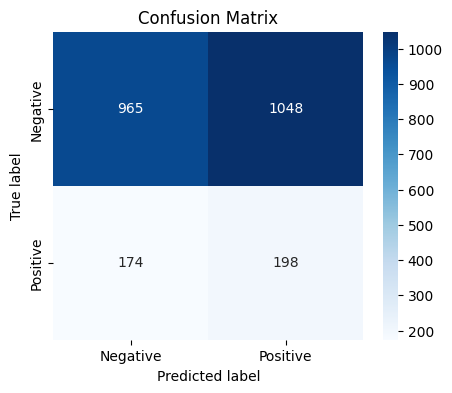

In [63]:
# Test LSTM
train_and_test(LSTMModel, train_sequences, train_labels, test_sequences, test_labels)

Epoch 1/10


/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - accuracy: 0.5116 - loss: 0.6930
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - accuracy: 0.6189 - loss: 0.6759
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.7471 - loss: 0.5421
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.8499 - loss: 0.3647
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.9243 - loss: 0.2187
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.9519 - loss: 0.1378
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - accuracy: 0.9731 - loss: 0.0882
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.9891 - loss: 0.0336
Epoch 9/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.9916 - loss: 0.0288
Epoch 10/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.9943 - loss: 0.0192
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step

=== Evaluation Metrics ===
Accuracy: 0.5346
Precision: 0.1670
Recall: 0.4973
F1_score: 0.2500
Roc_a

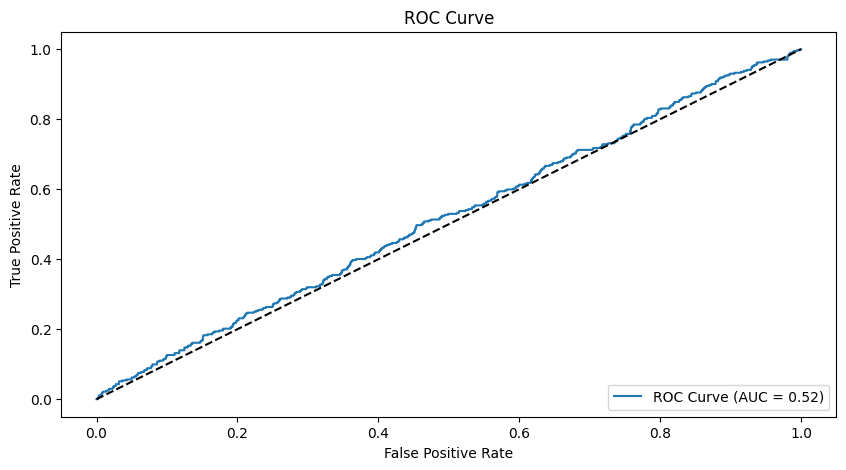

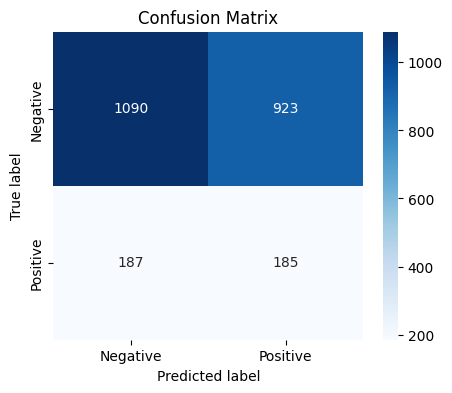

In [64]:
# Test GRU
train_and_test(GRUModel, train_sequences, train_labels, test_sequences, test_labels)

In [ ]:
# Test RNN with Attention
train_and_test(RNNAttentionModel, train_sequences, train_labels, test_sequences, test_labels)

In [ ]:
# Test CNN
train_and_test(CNNModel, train_sequences, train_labels, test_sequences, test_labels)

In [ ]:
# Test CNN with Attention
train_and_test(CNNAttentionModel, train_sequences, train_labels, test_sequences, test_labels)

In [ ]:
# Old cross validation code

def cross_validation(model_type, X_train, y_train, k=5, num_epochs=10, batch_size=128):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)

    true_labels = []
    predicted_labels = []

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    conf_matrix_sum = np.zeros((2, 2))
    accuracy_list = []

    for train_index, val_index in kfold.split(X_train):
        x_train_fold, x_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        tf.keras.backend.clear_session()
        model = create_model(model_type)

        model.fit(x_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, validation_data=(x_val_fold, y_val_fold), verbose=0)
        scores = model.evaluate(x_val_fold, y_val_fold, verbose=0)
        accuracy_list.append(scores[1])
        
        y_pred_probs_fold = model.predict(x_val_fold).ravel()
        y_pred_fold_binary = np.round(y_pred_probs_fold).astype(int)
        
        true_labels.extend(y_val_fold.tolist())
        predicted_labels.extend(y_pred_fold_binary.tolist())

        fpr, tpr, thresholds = roc_curve(y_val_fold, y_pred_probs_fold)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        conf_matrix_fold = confusion_matrix(y_val_fold, y_pred_fold_binary)
        conf_matrix_sum += conf_matrix_fold

    print("Metrics for model type:", model_type)
    print("Classification Report:")
    print(classification_report(true_labels, predicted_labels))

    average_accuracy = np.mean(accuracy_list)
    print(f'Average Accuracy across {k} folds: {average_accuracy:.4f}')

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.figure(figsize=(4, 3))
    plt.plot(mean_fpr, mean_tpr, color='blue', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    conf_matrix_normalized_by_class = conf_matrix_sum / conf_matrix_sum.sum(axis=1, keepdims=True)
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix_normalized_by_class, annot=True, fmt=".2f", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Normalized Confusion Matrix')
    plt.show()